# ETL_EDA
This file records the process of acquiring raw data, traforming them, and loading them into a MongoDB. The data are store (almost) in their raw form.

## 1. Raw Data from NY Times 
The [dataset](https://github.com/nytimes/covid-19-data) is a continuously updated (daily) txt file in csv format. It contains the covid-19 cases and deaths in US states and counties (historical data that has the final counts at the end of each day)

In [3]:
import requests
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib
from datetime import datetime, timedelta, time

from matplotlib import pyplot as plt
import pymongo


urls = {'counties': 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv',
        'states': 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv',
        'us': 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv'}

filters = {'us': ['date'],
           'states': ['date', 'state'],
           'counties': ['date', 'state', 'county']}

## 2. Raw Data to Documents/Dicts
Using pandas, it is simple to parse a in-memory string. The first few lines of description need to be skipped. Datetime conversion is made and blank lines are dropped. Now the data can be easily converted to a list of dicts which is what we want for the MongoDB.

In [11]:
df = pd.read_csv(StringIO(text), delimiter=',')
df.columns = df.columns.str.strip()             # remove space in columns name
df['date'] = pd.to_datetime(df['date'])
df.dropna(inplace=True)  
df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [7]:
df = pd.read_csv(StringIO(text), delimiter=',')
df.columns = df.columns.str.strip()             # remove space in columns name
df['date'] = pd.to_datetime(df['date'])
df.dropna(inplace=True)  
df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [9]:
df = pd.read_csv(StringIO(text), delimiter=',')
df.columns = df.columns.str.strip()             # remove space in columns name
df['date'] = pd.to_datetime(df['date'])
df.dropna(inplace=True)  
df.head()

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0


In [53]:
states = list(df['state'].unique())

## 3. Upsert MongoDB
If we fetch the data frequently, there are lots of duplicate data entry between each run. The de-duplication happens at insertion. The MongoDB API to use is `collection.replace_one(filter=..., replacement=..., upsert=True)`. The statement matches a document in MongoDB with `filter`, replaces it with `replacement` if the document exists or inserts `replacement` into the database if `filter` matches nothing. 

In [1]:
# from data_acquire import data_fetch
def data_fetch(geo):
    client = pymongo.MongoClient()
    
    # get url
    url = urls[geo]
    
    # raw data from nyt
    req = requests.get(url, timeout=1)
    req.raise_for_status()
    text = req.text

    # raw data to df
    df = pd.read_csv(StringIO(text), delimiter=',')
    df.columns = df.columns.str.strip()             # remove space in columns name
    df['date'] = pd.to_datetime(df['date'])
    df.dropna(inplace=True)  
    df.head()

    # upsert mangodb
    db = client.get_database(geo)   
    collection = db.get_collection(geo) 

    update_count = 0
    for record in df.to_dict('records'):
        result = collection.replace_one(
            filter={_:record[_] for _ in filters[geo]},    # locate the document if exists
            replacement=record,                         # latest document
            upsert=True)                                # update if exists, insert if not
        if result.matched_count > 0:
            update_count += 1
    print(f'{geo}:', 
          f'rows={df.shape[0]}, update={update_count}, '
          f'insert={df.shape[0]-update_count}')

In [4]:
# %%time
# for geo in list(urls.keys()):
#     data_fetch(geo)
data_fetch('us')

us: rows=691, update=0, insert=691


In [2]:
# # db = client.get_database(geo)   
# # collection = db.get_collection(geo) 

# update_count = 0
# for record in df.to_dict('us'):
#     print(record)
#     result = collection.replace_one(
#         filter={_:record[_] for _ in filters[geo]},    # locate the document if exists
#         replacement=record,                         # latest document
#         upsert=True)                                # update if exists, insert if not
#     if result.matched_count > 0:
#         update_count += 1
# print(f"rows={df.shape[0]}, update={update_count}, "
#       f"insert={df.shape[0]-update_count}")

## Use the smallest datset -- 'us' for EDA.
### 1. Accumulated cases

In [9]:
client.get_database("us")

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'us')

In [10]:
client = pymongo.MongoClient()
db = client.get_database("us") # to-do: combine the three database into the same one...
collection = db.get_collection("us")
data = list(collection.find())
df = pd.DataFrame.from_records(data)    
df.drop('_id', axis=1, inplace=True)
df

,date,cases,deaths
0,2020-01-21,1,0
1,2020-01-22,1,0
2,2020-01-23,1,0
3,2020-01-24,2,0
4,2020-01-25,3,0
...,...,...,...
685,2021-12-06,49242271,788315
686,2021-12-07,49356263,790082
687,2021-12-08,49505304,791933
688,2021-12-09,49628788,793227


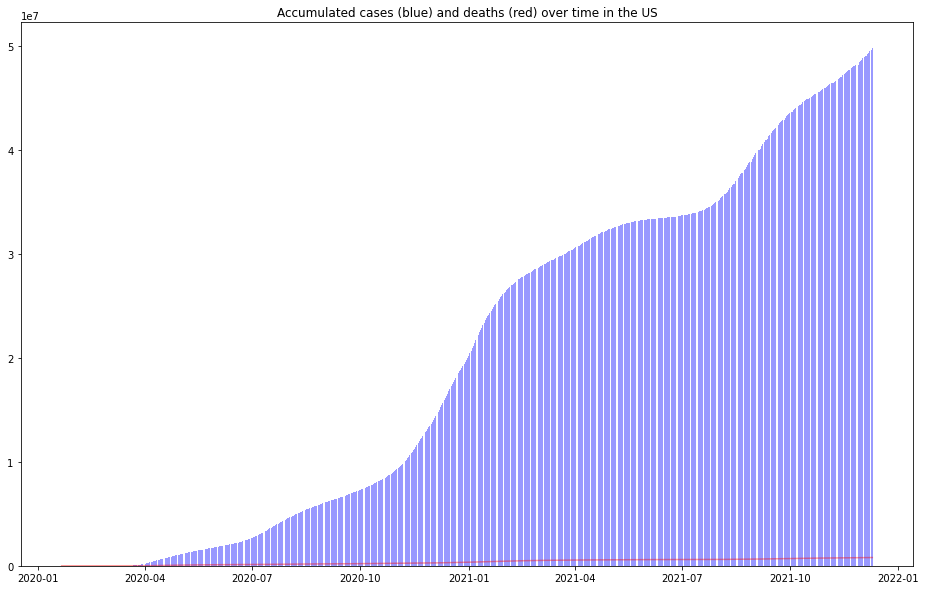

In [11]:
plt.figure(figsize=(16, 10))

plt.bar(df.date.values, df.cases.values, color = 'blue' , label='Cases over time', alpha=0.4)
plt.plot(df.date.values, df.deaths.values, color = 'red', label='Deaths over time', alpha=0.4)
plt.title('Accumulated cases (blue) and deaths (red) over time in the US')

plt.show()

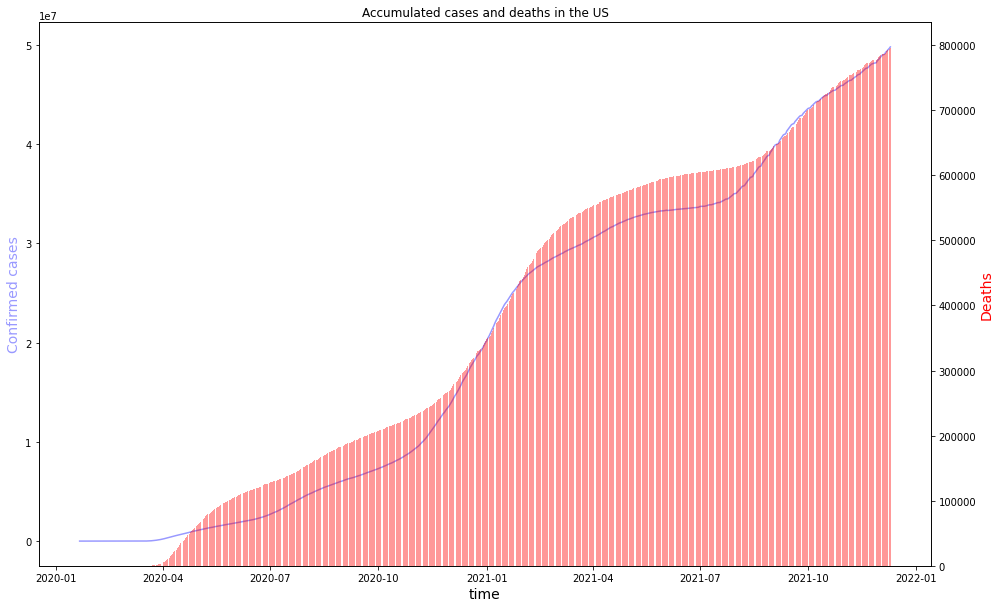

In [12]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(16, 10))

# make a plot
ax.plot(df.date.values, df.cases.values, color = 'blue' , label='Cases over time', alpha=0.4)

# set x-axis label
ax.set_xlabel("time",fontsize=14)
# set y-axis label
ax.set_ylabel("Confirmed cases", color="blue",fontsize=14, alpha=0.4)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.bar(df.date.values, df.deaths.values, color = 'red', label='Deaths over time', alpha=0.4)
ax2.set_ylabel("Deaths",color="red",fontsize=14)

plt.title('Accumulated cases and deaths in the US')
plt.show()
# # save the plot as a file
# fig.savefig('two_different_y_axis_for_single_python_plot_with_twinx.jpg',
#             format='jpeg',
#             dpi=100,

### 2. Daily cases and deaths
adjusted based on the code shown here: https://github.com/therealcyberlord/coronavirus_visualization_and_prediction/blob/master/coronavirus-covid-19-visualization-prediction.ipynb

In [13]:
def ç(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

def moving_average(data, window_size):
    moving_average = []
    for i in range(len(data)):
        if i + window_size < len(data):
            moving_average.append(np.mean(data[i:i+window_size]))
        else:
            moving_average.append(np.mean(data[i:len(data)]))
    return moving_average

# window size
window = 7

In [14]:
us_daily_case = daily_increase(df.cases)
us_wavg_case = moving_average(us_daily_case, 7)

us_daily_deatlh = daily_increase(df.deaths)
us_wavg_death = moving_average(us_daily_deatlh, 7)

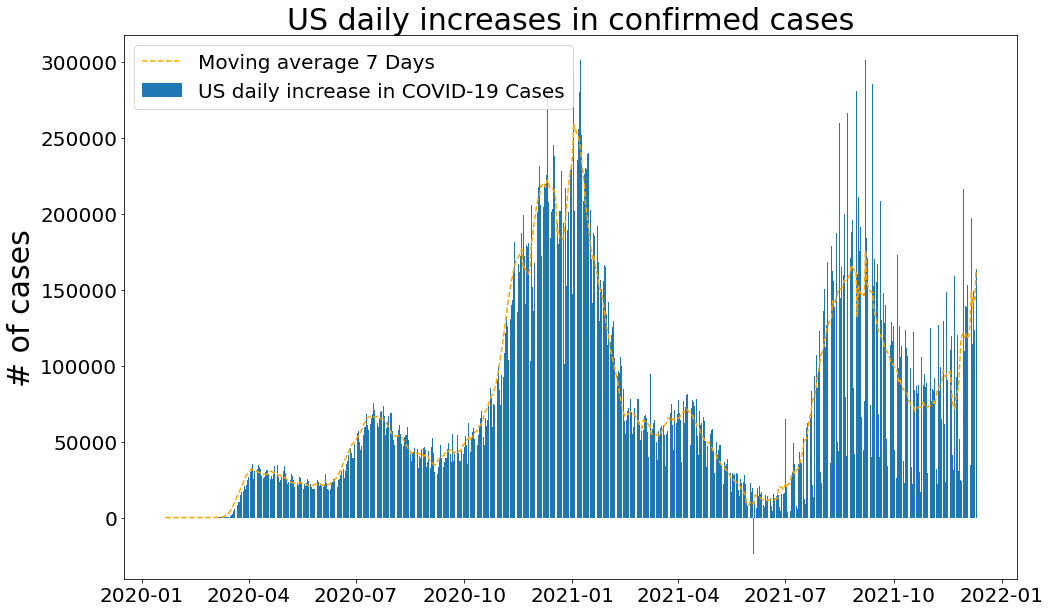

In [15]:
plt.figure(figsize=(16, 10))
plt.bar(df.date.values, us_daily_case)
plt.plot(df.date.values, us_wavg_case, color='orange', linestyle='dashed')
plt.title('US daily increases in confirmed cases', size=30)

plt.ylabel('# of cases', size=30)
plt.legend(['Moving average 7 Days', 'US daily increase in COVID-19 Cases'], prop={'size': 20})
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

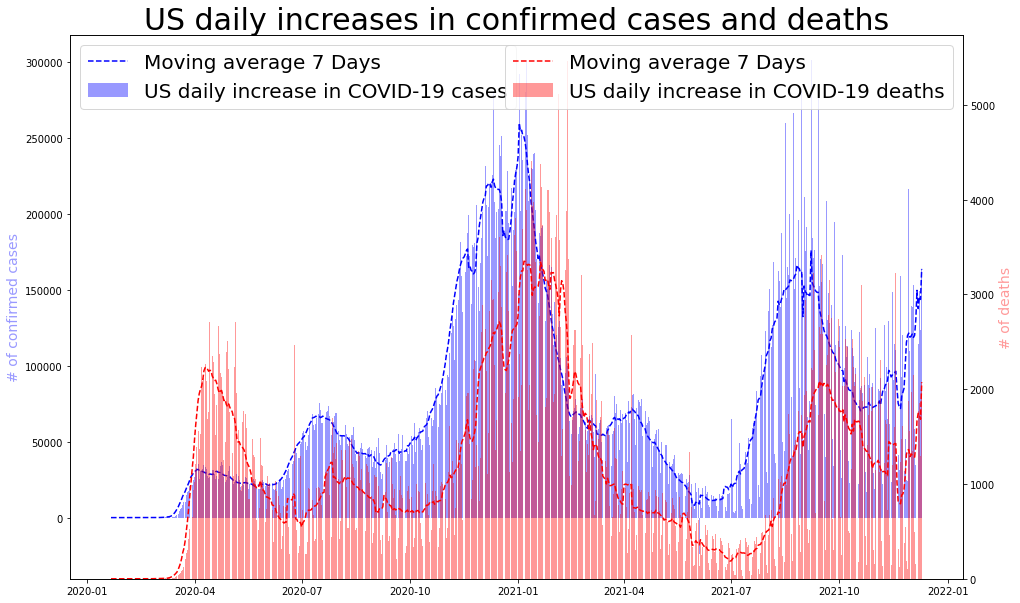

In [52]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(16, 10))

ax.bar(df.date.values, us_daily_case, color='blue', alpha=0.4)
ax.plot(df.date.values, us_wavg_case, color='blue', linestyle='dashed')

ax.set_ylabel('# of confirmed cases', color='blue', alpha=0.4, size=14)
ax.legend(['Moving average 7 Days', 'US daily increase in COVID-19 cases'], prop={'size': 20}, loc=2)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.bar(df.date.values, us_daily_deatlh, color = 'red', label='Deaths over time', alpha=0.4)
ax2.plot(df.date.values, us_wavg_death, color='red', linestyle='dashed')

ax2.set_ylabel("# of deaths", color = 'red', alpha=0.4, fontsize=14)
ax2.legend(['Moving average 7 Days', 'US daily increase in COVID-19 deaths'], prop={'size': 20}, loc=1)


plt.title('US daily increases in confirmed cases and deaths', size=30)
plt.show()

## Use the state datset -- 'states' for EDA
### Use the latest data (most updated)

In [19]:
data_fetch('states')

states: rows=35734, update=10179, insert=25555


In [20]:
client = pymongo.MongoClient()
db = client.get_database("states")
collection = db.get_collection("states")
data = list(collection.find())
df_s = pd.DataFrame.from_records(data)    
df_s.drop('_id', axis=1, inplace=True)
df_s

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0
...,...,...,...,...,...
35729,2021-12-10,Virginia,51,994069,14895
35730,2021-12-10,Washington,53,793102,9602
35731,2021-12-10,West Virginia,54,305418,5085
35732,2021-12-10,Wisconsin,55,1024195,10386


In [21]:
df_today = df_s[df_s.date==max(df_s.date)]
df_today.head()

,date,state,fips,cases,deaths
35678,2021-12-10,Alabama,1,851237,16243
35679,2021-12-10,Alaska,2,152422,862
35680,2021-12-10,American Samoa,60,1,0
35681,2021-12-10,Arizona,4,1309184,22947
35682,2021-12-10,Arkansas,5,537461,8831


In [22]:
yester = (max(df_s.date) - timedelta(days=1)).strftime('%Y-%m-%d')
df_yest = df_s[df_s.date==yester]
df_yest.head()

,date,state,fips,cases,deaths
35622,2021-12-09,Alabama,1,850645,16203
35623,2021-12-09,Alaska,2,151979,862
35624,2021-12-09,American Samoa,60,1,0
35625,2021-12-09,Arizona,4,1305260,22854
35626,2021-12-09,Arkansas,5,536368,8810


In [23]:
df_24 = pd.DataFrame(df_today.cases.values - df_yest.cases.values, columns=['cases'], index=df_today.state.values)
df_24_death = pd.DataFrame(df_today.deaths.values - df_yest.deaths.values, columns=['deaths'], index=df_today.state.values)
df_24m = df_24.merge(df_24_death, on=df_24_death.index)
df_24m = df_24m.rename(columns={'key_0': 'state'})
df_24m.columns

Index(['state', 'cases', 'deaths'], dtype='object')

In [24]:
def prepare_pie(cases, states):
    '''
    cases: formatted as df_today_sorted.cases
    states: df_today_sorted.states

    '''
    visual_unique_states = [] 
    visual_confirmed_cases = []
    others = np.sum(cases[10:])

    for i in range(len(cases[:10])):
        visual_unique_states.append(list(states)[i])
        visual_confirmed_cases.append(np.array(cases)[i])
    
    visual_unique_states.append('Others')
    visual_confirmed_cases.append(others)

    return (visual_unique_states, visual_confirmed_cases)

In [25]:
def plot_pie_charts(x, y, title):
    # more muted color 
    c = ['lightcoral', 'rosybrown', 'sandybrown', 'navajowhite', 'gold',
        'khaki', 'lightskyblue', 'turquoise', 'lightslategrey', 'thistle', 'pink']
    plt.figure(figsize=(20,15))
    plt.title(title, size=20)
    plt.pie(y, shadow=True, colors=c, labels=y)  
    plt.legend(x, loc='best', fontsize=12)
    plt.show()

### What happened for the last 24 hours?

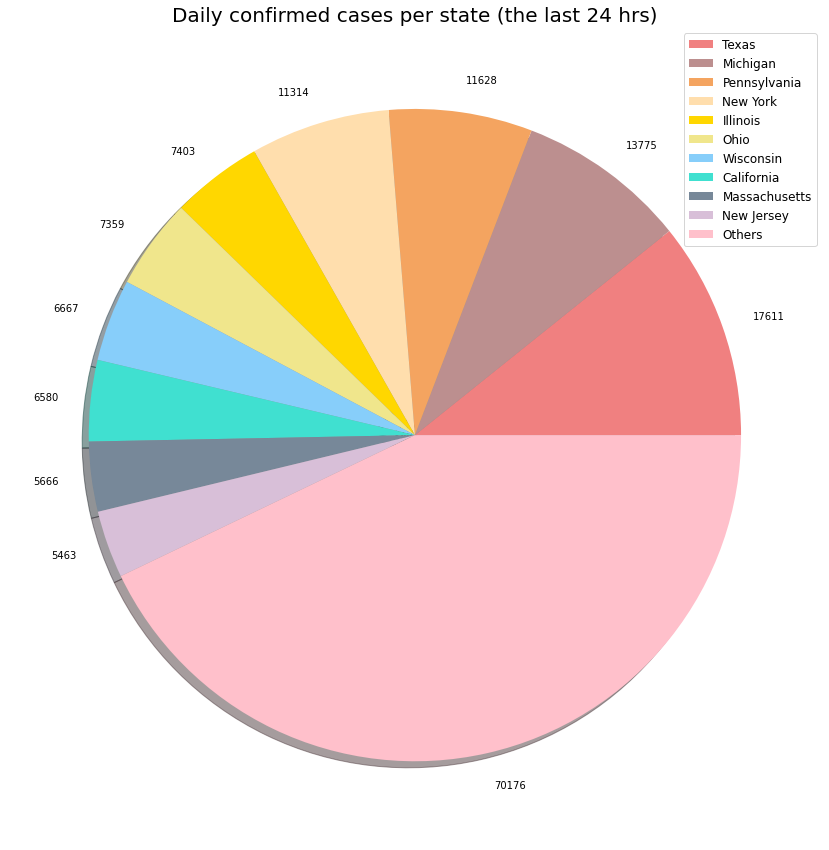

In [26]:
df_24_sorted_c = df_24m.sort_values(by=['cases'], ascending=False)
visual_unique_states, visual_confirmed_cases = prepare_pie(df_24_sorted_c.cases, df_24_sorted_c.state)
plot_pie_charts(visual_unique_states, visual_confirmed_cases, 'Daily confirmed cases per state (the last 24 hrs)')

Text(0.5, 1.0, 'Daily confirmed cases per state (the last 24 hrs)')

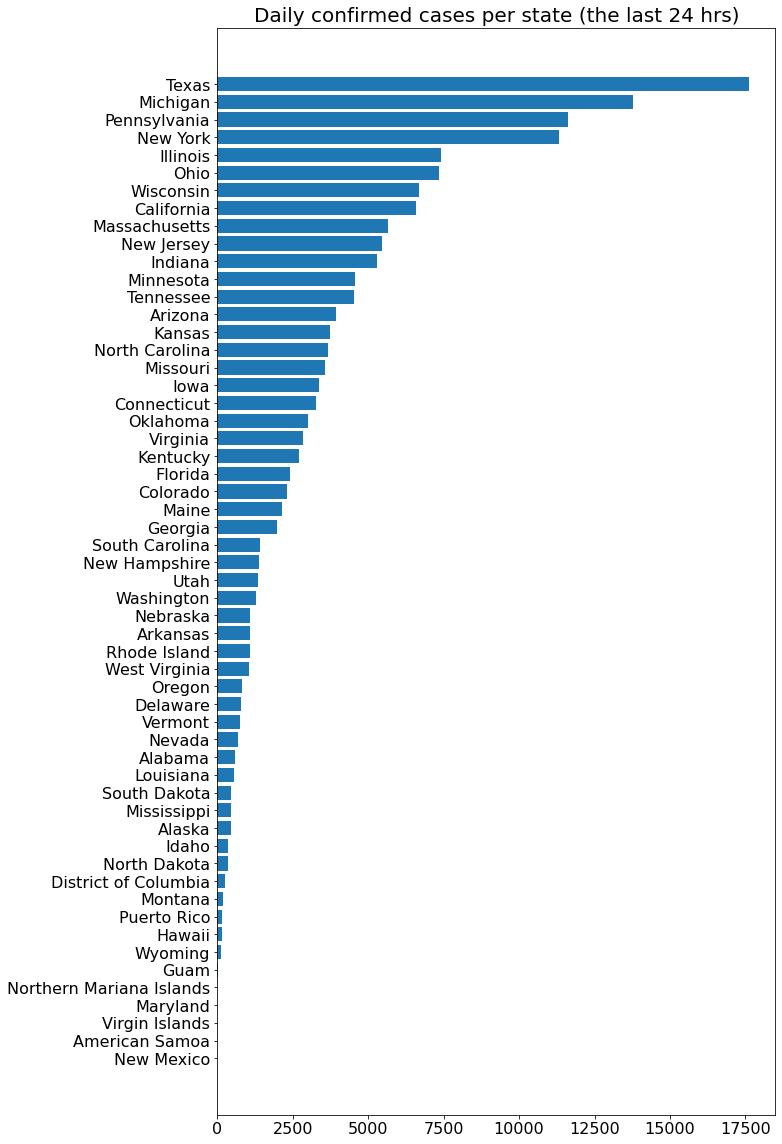

In [27]:
plt.figure(figsize=(10,20))
df_24_sorted_c = df_24m.sort_values(by=['cases'])
plt.barh(df_24_sorted_c.state, df_24_sorted_c.cases)
plt.tick_params(labelsize=16)
plt.title('Daily confirmed cases per state (the last 24 hrs)', size=20)

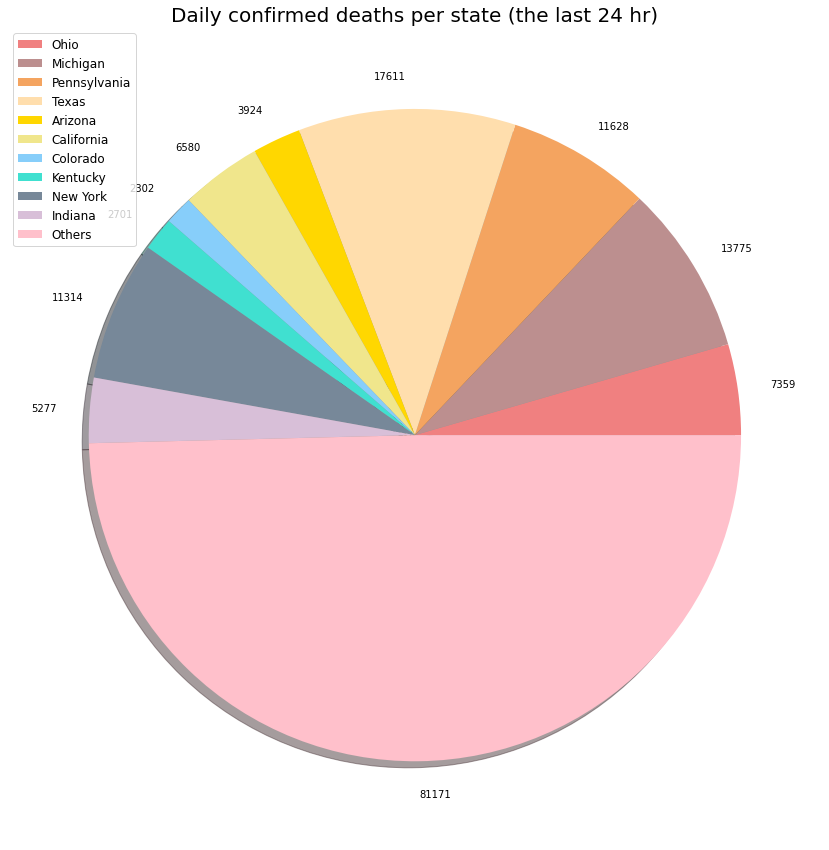

In [28]:
df_24_sorted_d = df_24m.sort_values(by=['deaths'], ascending=False)

visual_unique_states, visual_confirmed_cases = prepare_pie(df_24_sorted_d.cases, df_24_sorted_d.state)
plot_pie_charts(visual_unique_states, visual_confirmed_cases, 'Daily confirmed deaths per state (the last 24 hr)')

Text(0.5, 1.0, 'Daily confirmed cases per state (the last 24 hrs)')

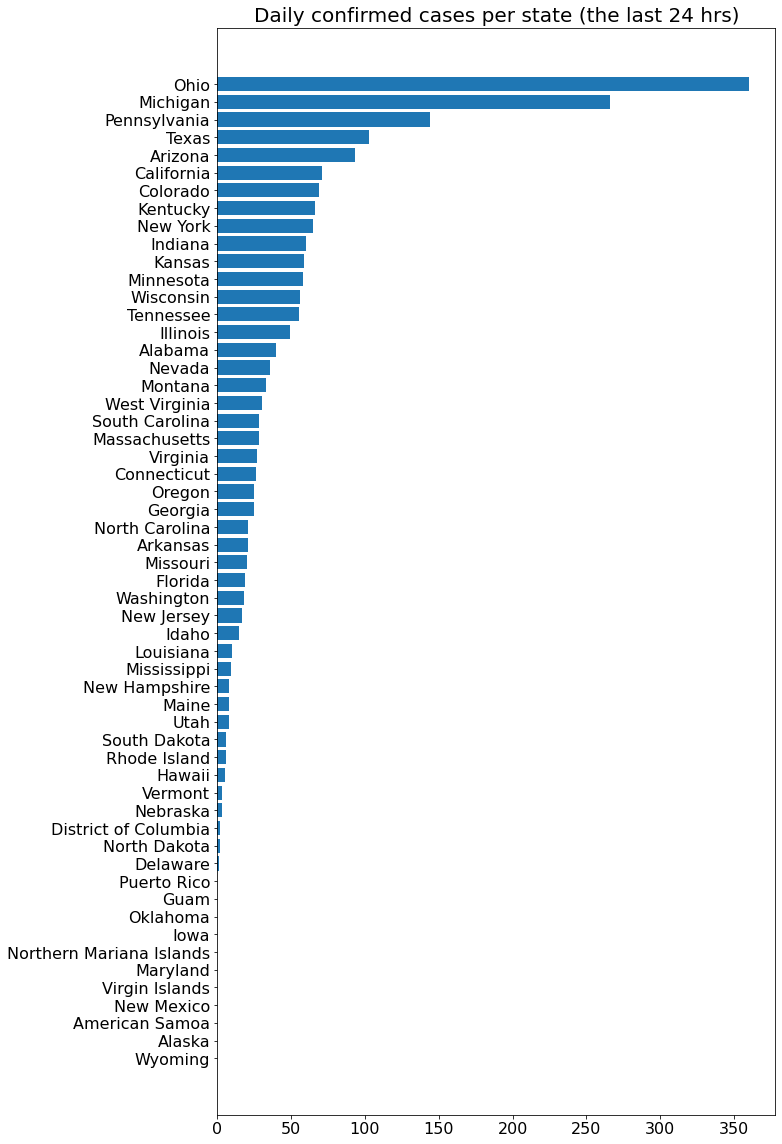

In [29]:
plt.figure(figsize=(10,20))
df_24_sorted_d = df_24m.sort_values(by=['deaths'])

plt.barh(df_24_sorted_d.state, df_24_sorted_d.deaths)
plt.tick_params(labelsize=16)
plt.title('Daily confirmed cases per state (the last 24 hrs)', size=20)

### The most updated accumulated cases and deaths in each state

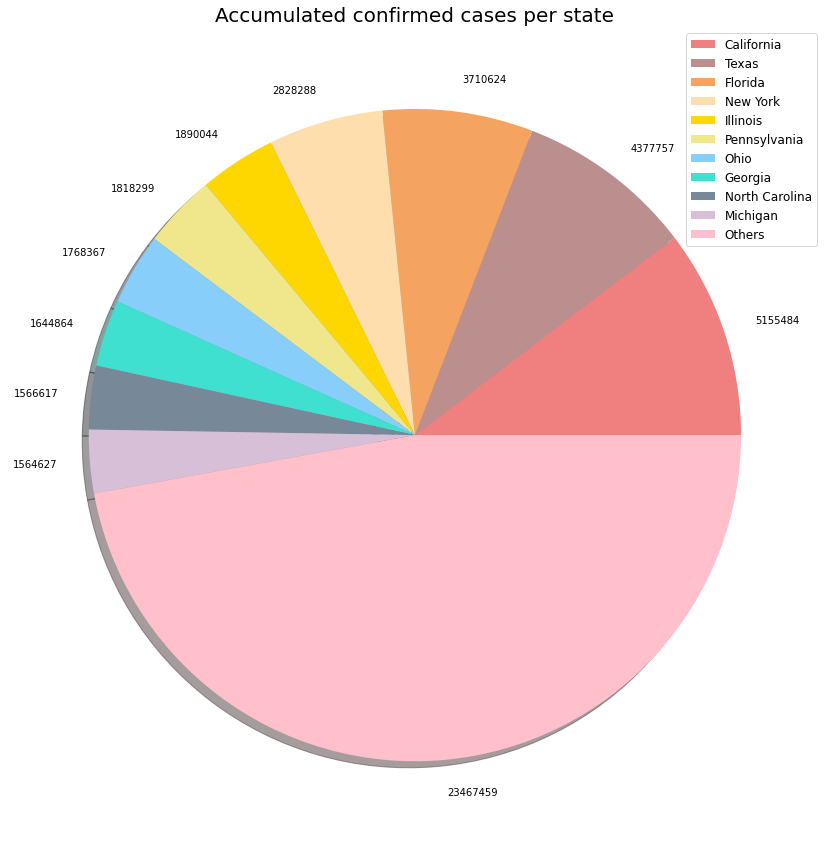

In [30]:
df_today_sorted = df_today.sort_values(by=['cases'], ascending=False)
visual_unique_states, visual_confirmed_cases = prepare_pie(df_today_sorted.cases, df_today_sorted.state)
plot_pie_charts(visual_unique_states, visual_confirmed_cases, 'Accumulated confirmed cases per state')

Text(0.5, 1.0, 'Accumulated confirmed cases per state')

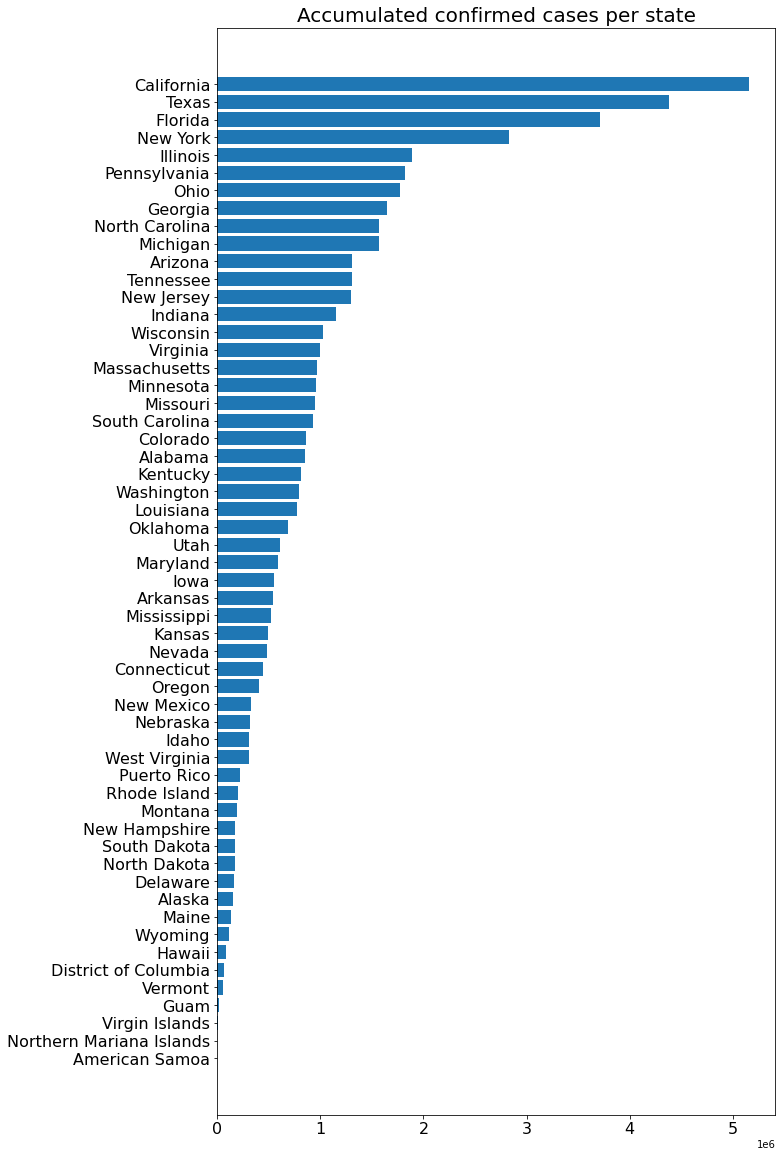

In [33]:

plt.figure(figsize=(10,20))
df_today_sorted = df_today.sort_values(by=['cases'])

plt.barh(df_today_sorted.state, df_today_sorted.cases)
plt.tick_params(labelsize=16)
plt.title('Accumulated confirmed cases per state', size=20)


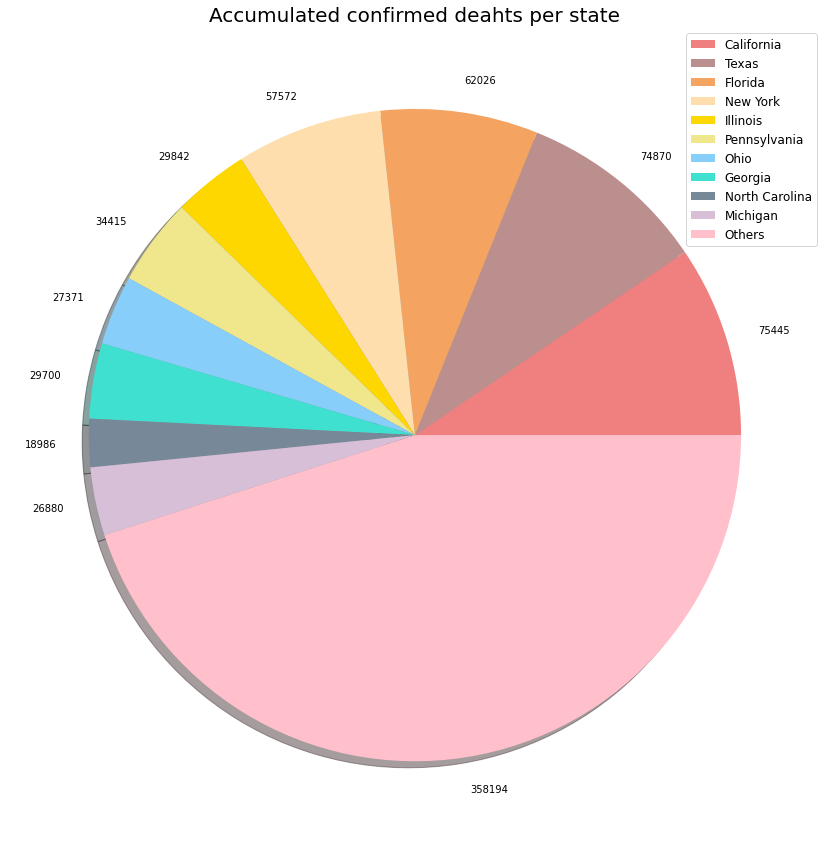

In [46]:
df_today_sorted = df_today.sort_values(by=['cases'], ascending=False)
visual_unique_states, visual_confirmed_cases = prepare_pie(df_today_sorted.deaths, df_today_sorted.state)
plot_pie_charts(visual_unique_states, visual_confirmed_cases, 'Accumulated confirmed deahts per state')

Text(0.5, 1.0, 'Accumulated confirmed cases per state')

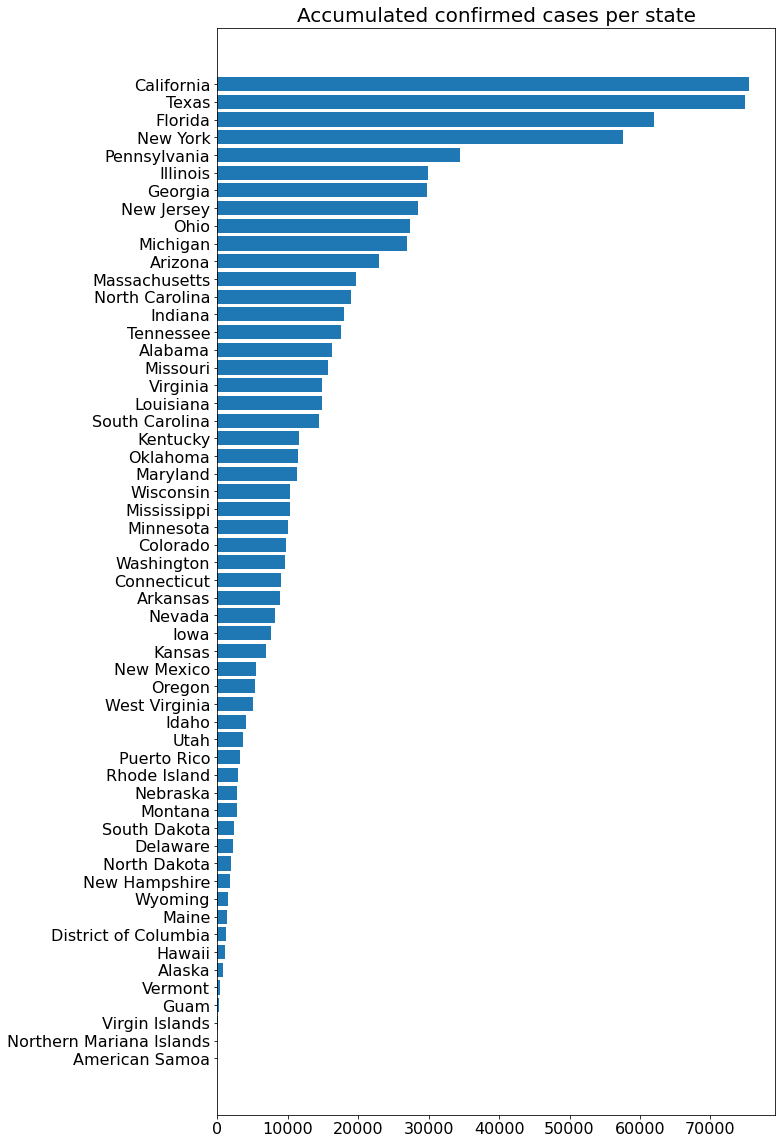

In [35]:

plt.figure(figsize=(10,20))
df_today_sorted = df_today.sort_values(by=['deaths'])

plt.barh(df_today_sorted.state, df_today_sorted.deaths)
plt.tick_params(labelsize=16)
plt.title('Accumulated confirmed cases per state', size=20)


### State-wise daily increase 

In [142]:
def state_daily(df, state):
    df = df[df.state == state]
    df = df.sort_values(by=['date'])
    dates = df.date.values
    cases = df.cases.values
    deaths = df.deaths.values
    cases_daily = daily_increase(cases)
    deaths_daily = daily_increase(deaths)
    
    cases_avg = moving_average(cases_daily, 7)
    deaths_avg = moving_average(deaths_daily, 7)

    # create figure and axis objects with subplots()
    fig,ax = plt.subplots()
    ax.bar(dates, cases_daily, color='blue', alpha=0.4)
    ax.plot(dates, cases_avg, color='blue', linestyle='dashed')

    ax.set_xlabel(state, size=14)
    ax.set_ylabel('# of confirmed cases', color='blue', alpha=0.4, size=14)
    ax.set_ylim([0, max(cases_daily)])
    #ax.legend(['Moving average 7 Days', 'US daily increase in COVID-19 cases'], prop={'size': 20}, loc=2)

    # twin object for two different y-axis on the sample plot
    ax2=ax.twinx()
    
    # make a plot with different y-axis using second axis object
    ax2.bar(dates, deaths_daily, color = 'red', label='Deaths over time', alpha=0.4)
    ax2.plot(dates, deaths_avg, color='red', linestyle='dashed')
            
    ax2.set_ylabel("# of deaths", color = 'red', alpha=0.4, fontsize=14)
    ax2.set_ylim([-max(deaths_daily)/2, max(deaths_daily)])
    plt.show()
#    # ax2.legend(['Moving average 7 Days', 'US daily increase in COVID-19 deaths'], prop={'size': 20}, loc=1)


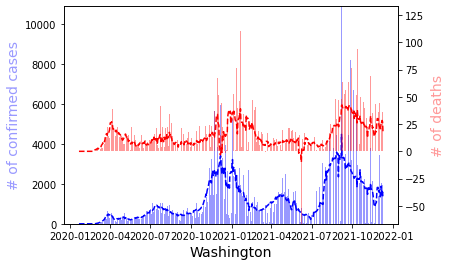

In [143]:
 state_daily(df_s, 'Washington')

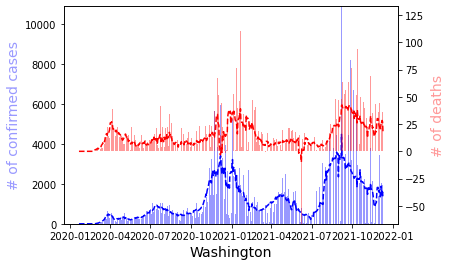

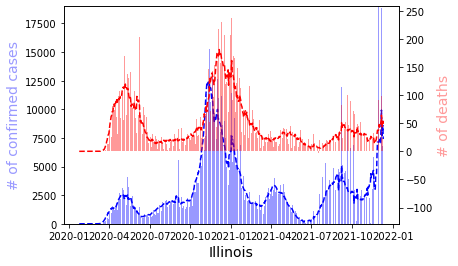

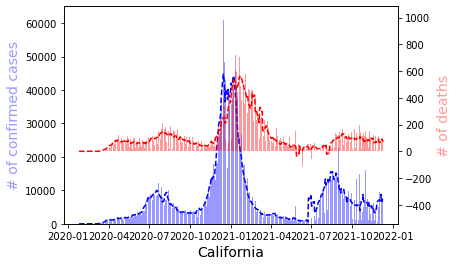

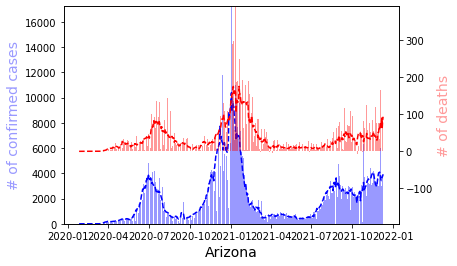

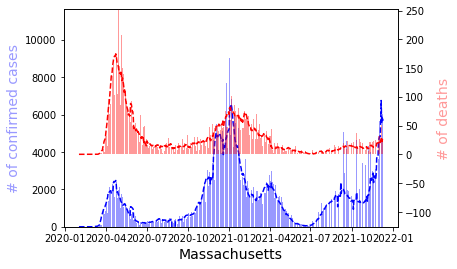

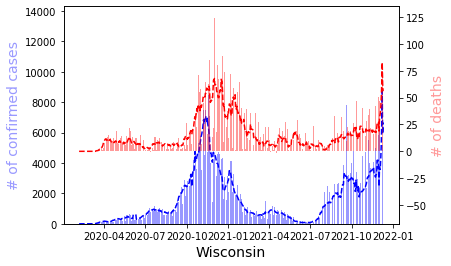

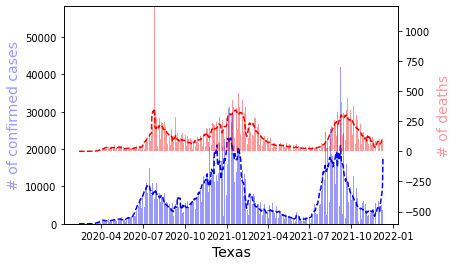

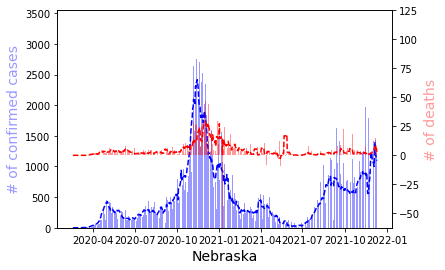

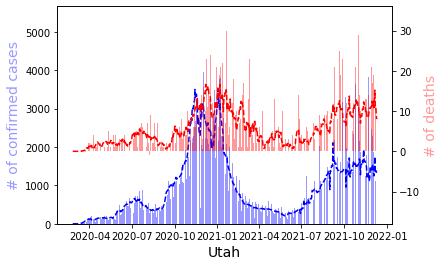

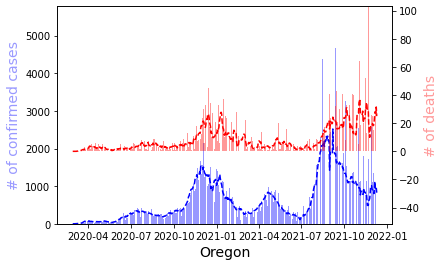

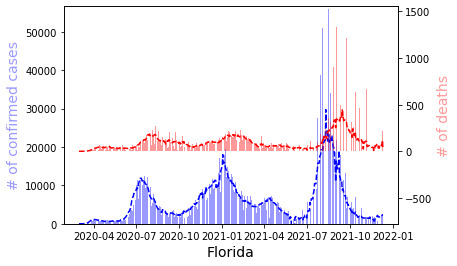

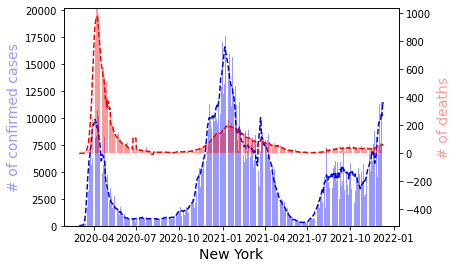

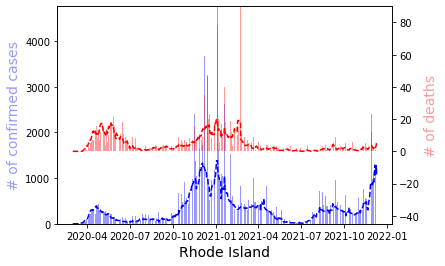

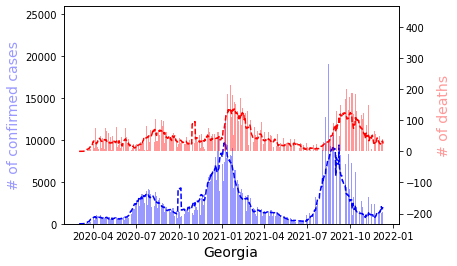

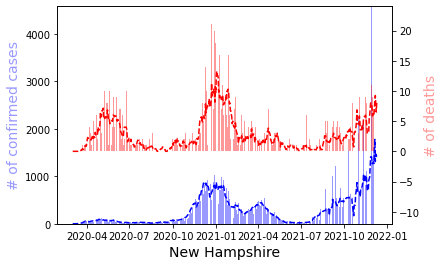

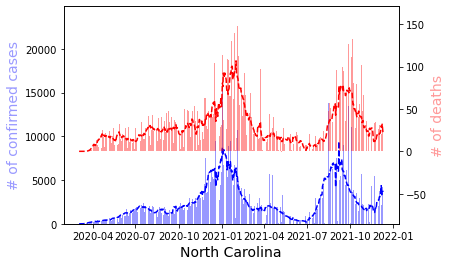

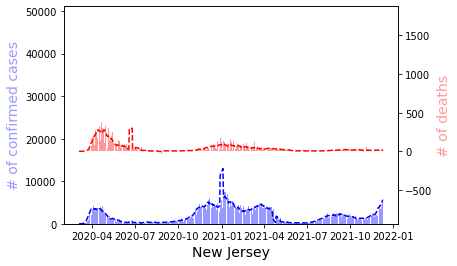

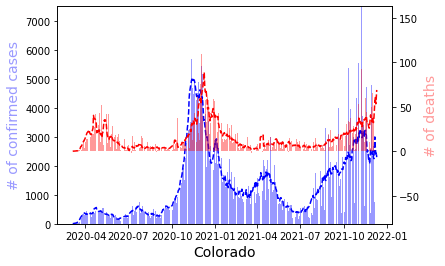

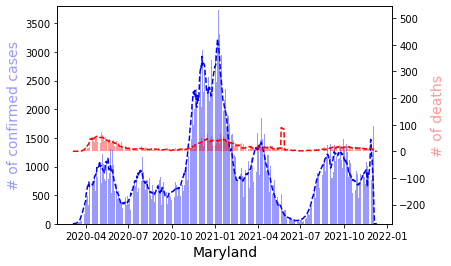

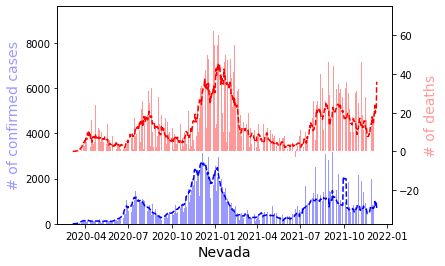

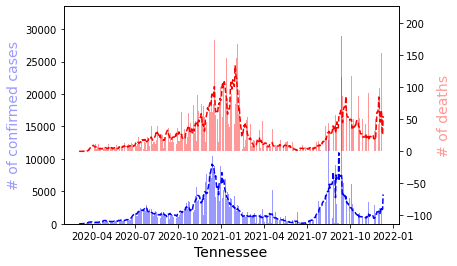

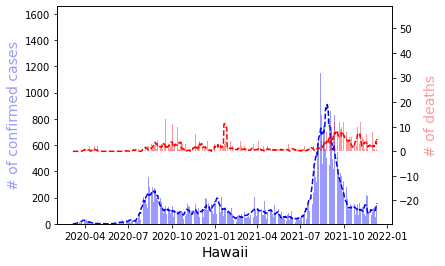

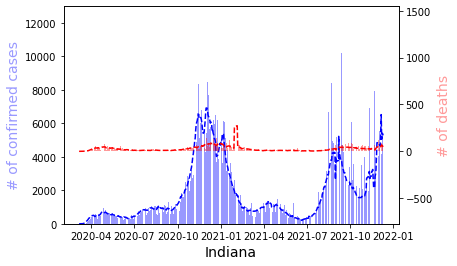

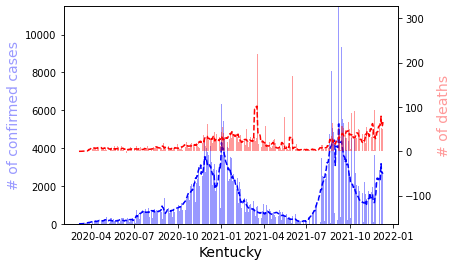

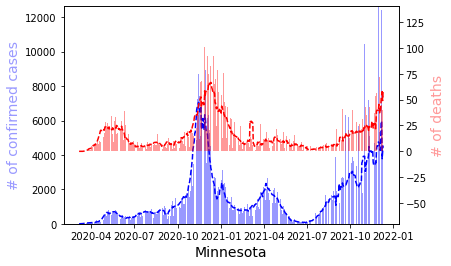

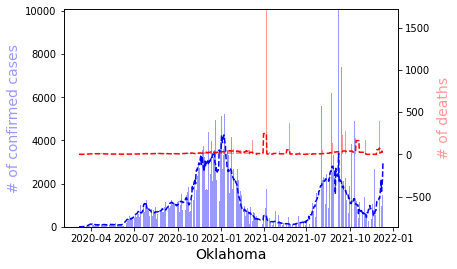

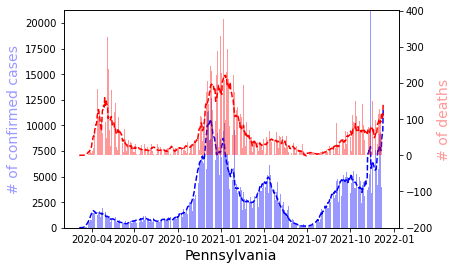

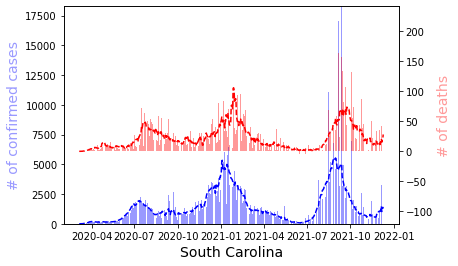

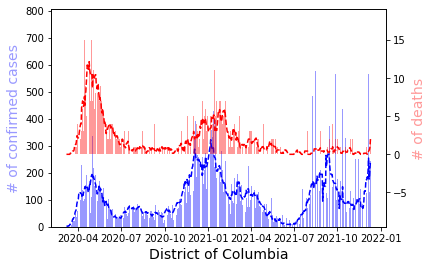

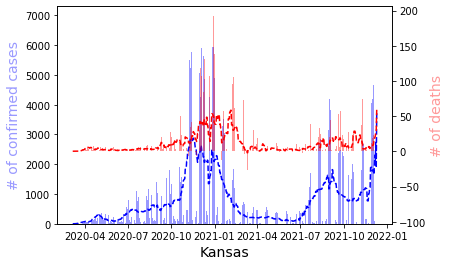

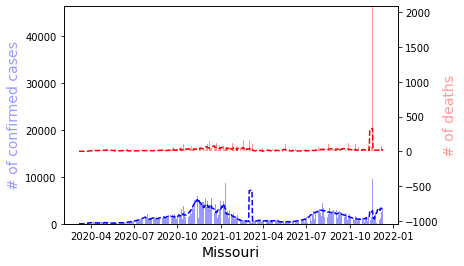

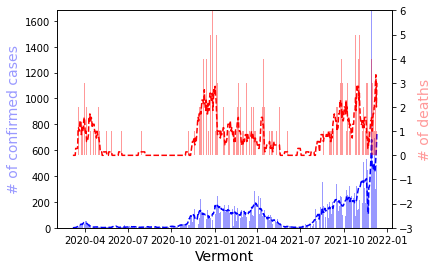

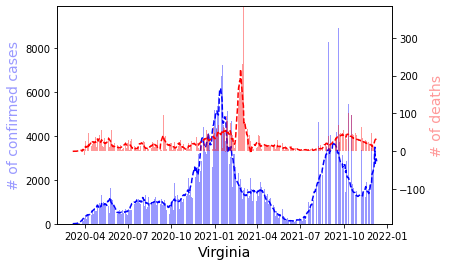

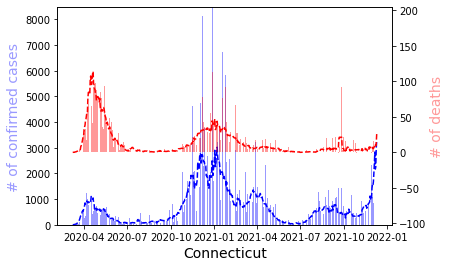

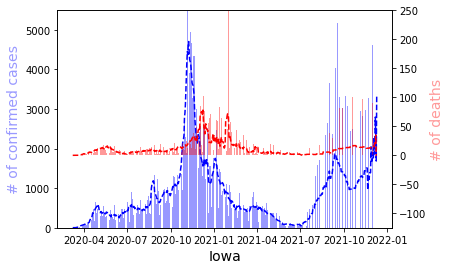

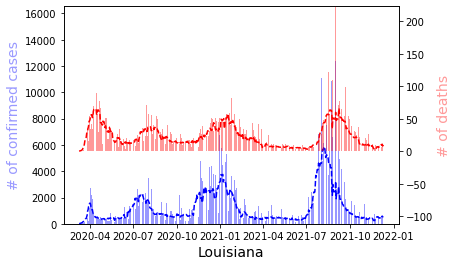

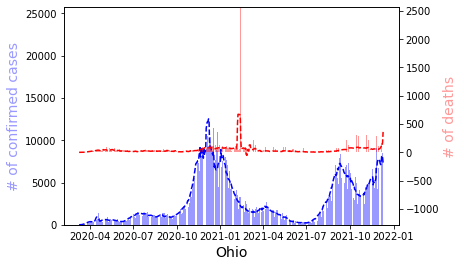

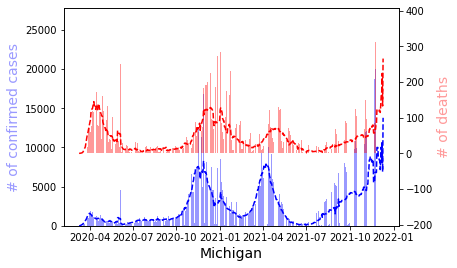

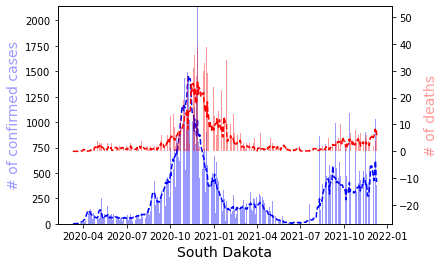

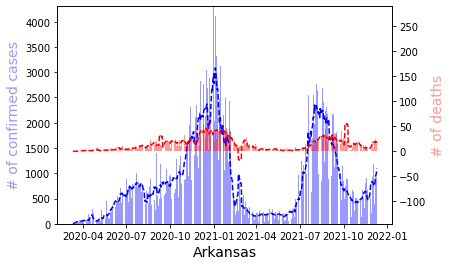

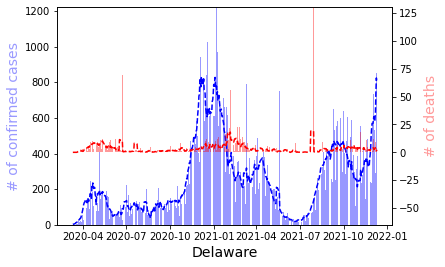

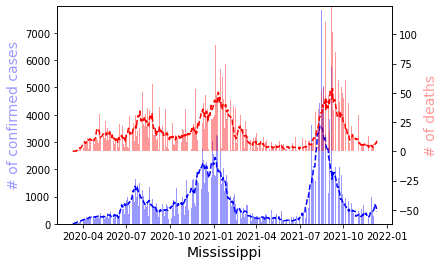

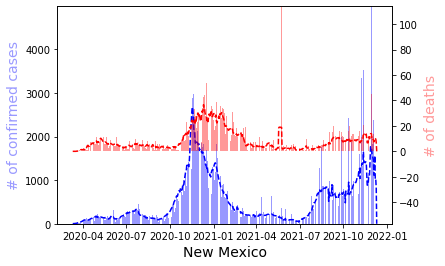

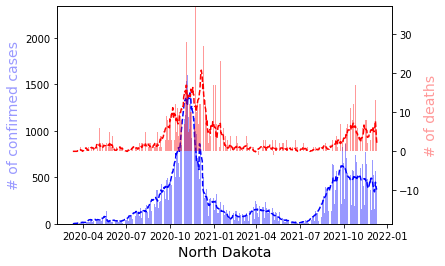

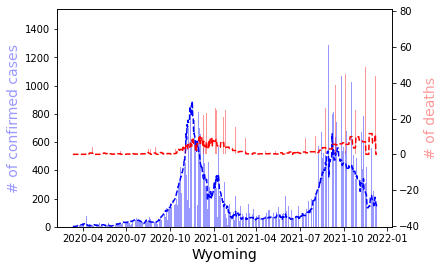

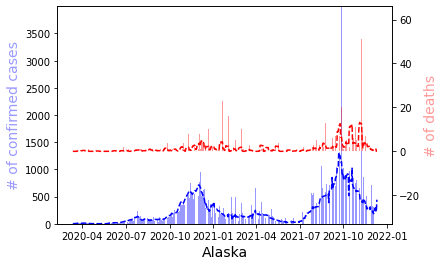

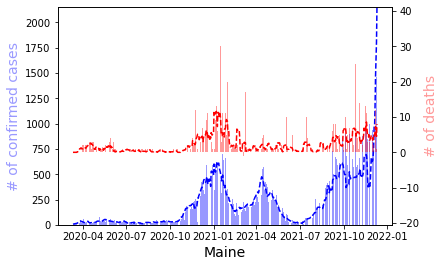

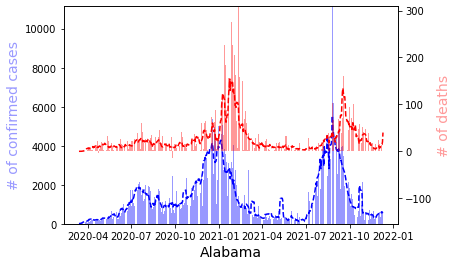

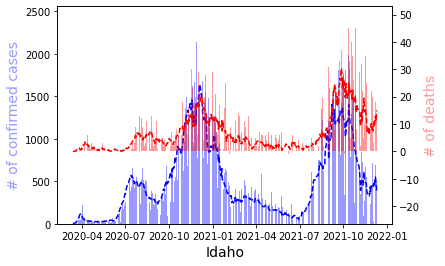

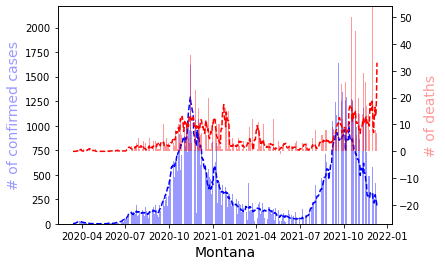

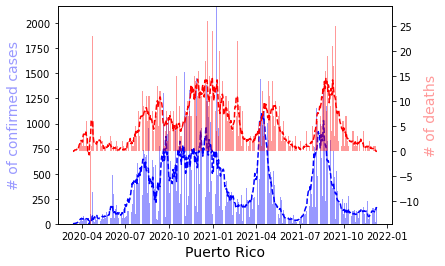

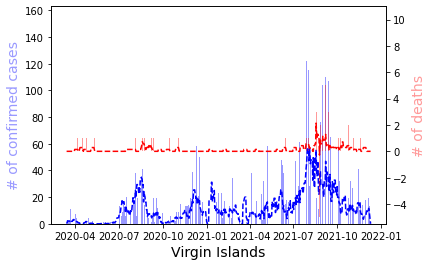

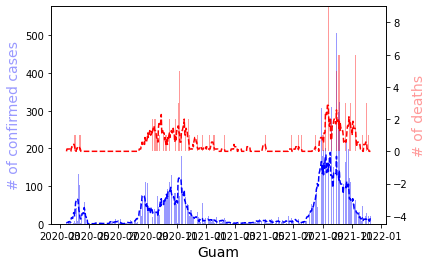

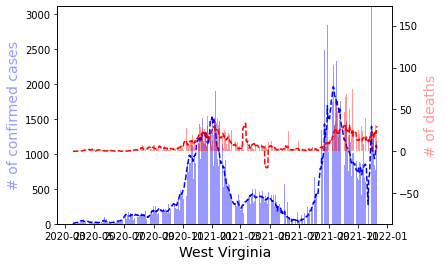

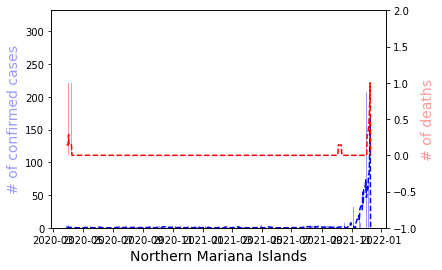

/tmp/ipykernel_2072/2005776977.py:31: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax2.set_ylim([-max(deaths_daily)/2, max(deaths_daily)])


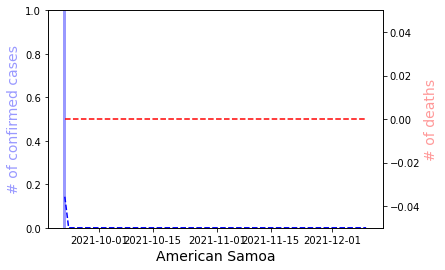

In [145]:
for state in df_s.state.unique():
    state_daily(df_s, state)

In [147]:
df_today

,date,state,fips,cases,deaths
35678,2021-12-10,Alabama,1,851237,16243
35679,2021-12-10,Alaska,2,152422,862
35680,2021-12-10,American Samoa,60,1,0
35681,2021-12-10,Arizona,4,1309184,22947
35682,2021-12-10,Arkansas,5,537461,8831
35683,2021-12-10,California,6,5155484,75445
35684,2021-12-10,Colorado,8,859186,9813
35685,2021-12-10,Connecticut,9,439423,8972
35686,2021-12-10,Delaware,10,159399,2211
35687,2021-12-10,District of Columbia,11,68702,1199


In [149]:
df_today.state.values

array(['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Guam', 'Hawaii',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
       'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Northern Mariana Islands',
       'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virgin Islands', 'Virginia',
       'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype=object)